# Predicting High-Rated Apps on Google Play

## Introduction

With millions of apps available on the Google Play Store, standing out and achieving high user ratings has become increasingly difficult for developers. While some apps accumulate strong reputations and loyal user bases, many struggle to gain visibility or traction despite similar functionality. Understanding what drives app success—particularly through measurable indicators such as user ratings—is essential for developers, marketers, and product strategists.

This project builds on previous exploratory analysis by developing a predictive model that classifies whether an app will achieve a high user rating (defined as a rating ≥ 4.5). Using features such as app category, pricing strategy, in-app purchases, user engagement, and content rating, the model aims to identify patterns that correlate with high user satisfaction.

By evaluating multiple classification algorithms—including logistic regression, decision trees, K-Nearest Neighbors (KNN), and random forests—this analysis not only compares model performance but also highlights which features are most influential in predicting high-rated apps. The insights derived can inform data-driven app design, category positioning, and monetization strategies.

**Task**: Binary classification — predict whether an app receives a high user rating (≥4.5) using features such as category, price, reviews, and in-app purchases.

In [ ]:
# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

# Settings
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## Dataset Description & Preparation
In this step, we continue using the cleaned dataset developed in the EDA phase. That version had already addressed missing values, standardized formats (e.g., install counts, size, and pricing), and ensured consistent data types across key columns. This allows us to build on a reliable and preprocessed foundation for predictive modeling.

To prepare the dataset for classification, we performed the following additional steps:


*   Target Creation: We introduced a binary target variable is_high_rating, where apps with a rating ≥ 4.5 are labeled as 1 (highly rated) and others as 0.
*   Feature Selection: Non-predictive or identifier columns such as App Name, App Id, and Developer Id were removed.
*   Encoding: Boolean columns were converted to integers (0/1), and categorical variables (e.g., Category, Content Rating) were one-hot encoded.
*   Scaling: Numerical features such as Rating Count, Price, and Size were standardized using StandardScaler.
*   Memory Optimization: Large integer-based columns (e.g., Installs, Rating Count) were downcast to more memory-efficient data types.
*   Train-Test Split: The dataset was split into training and testing sets using an 80/20 ratio, with stratification to preserve class balance.
*   Sampling: A 10% random sample was taken from both the training and testing sets to ensure efficient runtime during model training and hyperparameter tuning. Given the full dataset contains over 525,000 rows, the 10% sample (~52,500 rows) still provides ample data for modeling while significantly reducing computational cost.

These steps ensure that the feature matrix X and target vector y are formatted and scaled appropriately for input into various classification models.








In [ ]:
df = pd.read_csv("google_playstore_apps_cleaned.csv")

In [ ]:
df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Release Year
0,Gakondo,com.ishakwe.gakondo,1,0.0,0.0,10.0,10.0,15,1,0.0,USD,10000000.0,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,2020-02-26,Everyone,0,0,0,2020.0
1,Ampere Battery Info,com.webserveis.batteryinfo,42,4.4,64.0,5000.0,5000.0,7662,1,0.0,USD,2900000.0,5.0 and up,Webserveis,2021-05-06,Everyone,1,0,0,2020.0
2,Vibook,com.doantiepvien.crm,33,0.0,0.0,50.0,50.0,58,1,0.0,USD,3700000.0,4.0.3 and up,Cabin Crew,2019-08-19,Everyone,0,0,0,2019.0
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,13,5.0,5.0,10.0,10.0,19,1,0.0,USD,1800000.0,4.0.3 and up,Climate Smart Tech2,2018-10-13,Everyone,1,0,0,2018.0
4,GROW.me,com.horodyski.grower,42,0.0,0.0,100.0,100.0,478,1,0.0,USD,6200000.0,4.1 and up,Rafal Milek-Horodyski,2018-11-12,Everyone,0,0,0,2020.0


In [ ]:
# Memory Optimization & Cardinality Reduction

# To reduce memory usage and avoid excessive one-hot encoding during modeling,
# we limit high-cardinality categorical features to their most common values.
# Rare values are grouped under 'Other' to retain signal while avoiding overfitting or RAM crashes.
# Additionally, we downcast large numeric columns to more efficient data types.

# Reduce 'Minimum Android' to top 10 most frequent
top_android = df['Minimum Android'].value_counts().nlargest(10).index
df = df[df['Minimum Android'].isin(top_android)]

# Limit 'Category' to top 10 most common values
top_categories = df['Category'].value_counts().nlargest(10).index
df['Category'] = df['Category'].apply(lambda x: x if x in top_categories else 'Other')

# Limit 'Currency' to top 3 most common values
top_currencies = df['Currency'].value_counts().nlargest(3).index
df['Currency'] = df['Currency'].apply(lambda x: x if x in top_currencies else 'Other')

# Downcast numeric columns to reduce memory usage
for col in ['Installs', 'Minimum Installs', 'Maximum Installs', 'Rating Count']:
    df[col] = pd.to_numeric(df[col], downcast='integer')

In [ ]:
# Preprocessing and Splitting

# Create binary target: is_high_rating
df['is_high_rating'] = df['Rating'] >= 4.5
df['is_high_rating'] = df['is_high_rating'].astype(int)

# Drop non-predictive or ID columns
df_model = df.drop(columns=[
    'App Name', 'App Id', 'Rating', 'Developer Id', 'Last Updated'
])

# Encode boolean columns if not already in 0/1 format
bool_cols = ['Free', 'Ad Supported', 'In App Purchases', 'Editors Choice']
for col in bool_cols:
    df_model[col] = df_model[col].astype(int)

# One-hot encode categorical columns
df_model = pd.get_dummies(df_model, columns=[
    'Category', 'Content Rating', 'Currency', 'Minimum Android'
], drop_first=True)

# Drop 'Release Year' due to a high number of missing values and limited expected predictive power.
# This simplifies the model and avoids unnecessary imputation.
df_model = df_model.drop(columns=['Release Year'], errors='ignore')

# Define features (X) and target (y)
X = df_model.drop(columns=['is_high_rating'])
y = df_model['is_high_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
# Identify numeric columns
numeric_cols = ['Rating Count', 'Installs', 'Minimum Installs',
                'Maximum Installs', 'Price', 'Size']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
# Sampling for Runtime Efficiency and Model Consistency

# We use a 10% random sample of the training and test sets to ensure faster model training and tuning,
# especially for computationally intensive models like KNN and Random Forest with GridSearchCV.
# Given the full dataset contains approximately 525,000 rows, this sample includes about 52,500 data points.
# This subset still retains the overall distribution of the data due to stratified splitting,
# and all models are trained and evaluated on this same sample to allow fair and consistent comparison.
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

X_test_sample = X_test.sample(frac=0.1, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

In [ ]:
print("X_train_sample shape:", X_train_sample.shape)
print("X_test_sample shape:", X_test_sample.shape)

X_train_sample shape: (168214, 37)
X_test_sample shape: (42054, 37)


## Baseline Model

Adopting Logistic Regression model as baseline model.

In [ ]:
# Define feature groups
numeric_features = ['Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Price', 'Size']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [ ]:
# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# Build the pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [ ]:
# Fit model
logreg_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Rating Count', 'Installs',
                                                   'Minimum Installs',
                                                   'Maximum Installs', 'Price',
                                                   'Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))])...
                                                   'Content Rating_Teen',
                                                   'Content Rating_Unrated',
                                                   'Currency_USD',
                                                   'Currency_Unknown',
                                                   'Currency_XXX',
                                                   'Minimum Android_4.0 and up',
                                                   'Minimum Android_4.0.3 and '
                                                   'up',
                                                   'Minimum Android_4.1 and up',
                                                   'Minimum Android_4.2 and up',
                                                   'Minimum Android_4.4 and up',
                                                   'Minimum Android_5.0 and up',
                                                   'Minimum Android_5.1 and up',
                                                   'Minimum Android_6.0 and up', ...])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
# Predict and evaluate
y_pred_lr = logreg_pipeline.predict(X_test_sample)

print("🔍 Logistic Regression (Pipeline) Performance:")
print("Accuracy:", round(accuracy_score(y_test_sample, y_pred_lr), 3))
print("Precision:", round(precision_score(y_test_sample, y_pred_lr), 3))
print("Recall:", round(recall_score(y_test_sample, y_pred_lr), 3))
print("F1 Score:", round(f1_score(y_test_sample, y_pred_lr), 3))

🔍 Logistic Regression (Pipeline) Performance:
Accuracy: 0.816
Precision: 1.0
Recall: 0.0
F1 Score: 0.001


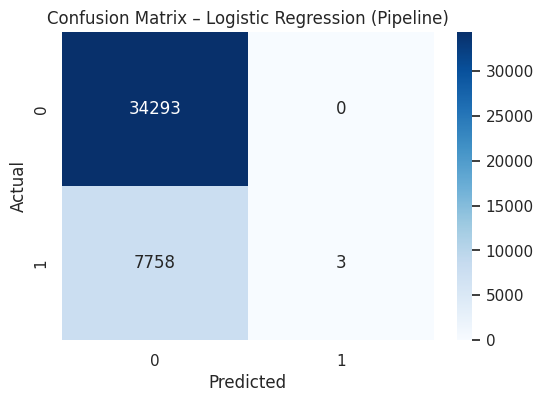


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     34293
           1       1.00      0.00      0.00      7761

    accuracy                           0.82     42054
   macro avg       0.91      0.50      0.45     42054
weighted avg       0.85      0.82      0.73     42054



In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_sample, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (Pipeline)")
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_sample, y_pred_lr))

The Logistic Regression model, implemented through a preprocessing pipeline, achieved an overall accuracy of 81.6%, with a precision of 1.00 but a recall of only 0.00 for the positive class (highly rated apps). The F1 score was effectively 0.001, indicating the model fails to identify any high-rated apps, despite being very conservative in its predictions. The confusion matrix confirms this imbalance: while all low-rated apps were correctly predicted (true negatives), nearly all high-rated apps were missed (false negatives). This suggests that while Logistic Regression provides a useful baseline, its linear nature makes it poorly suited for capturing the complex, nonlinear patterns needed to distinguish high-quality apps in this dataset.

## K-Nearest Neighbors Regression Model

In [ ]:
# Define feature groups
numeric_features = ['Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Price', 'Size']
categorical_features = [col for col in X.columns if col not in numeric_features]

# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# Build the KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Define hyperparameter grid and run GridSearchCV
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

grid_knn = GridSearchCV(knn_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_knn.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating '
                                                                          'Count',
                                                                          'Installs',
                                                                          'Minimum '
                                                                          'Installs',
                                                                          'Maximum '
                                                                          'Installs',
                                                                          'Price',
                                                                          'Size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotE...
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_4.0.3 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_4.1 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_4.2 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_4.4 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_5.0 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_5.1 '
                                                                          'and '
                                                        

In [ ]:
# Predict and evaluate
y_pred_knn = grid_knn.predict(X_test_sample)

print("Best KNN Parameters:", grid_knn.best_params_)
print("\nKNN Performance Metrics:")
print("Accuracy:", round(accuracy_score(y_test_sample, y_pred_knn), 3))
print("Precision:", round(precision_score(y_test_sample, y_pred_knn), 3))
print("Recall:", round(recall_score(y_test_sample, y_pred_knn), 3))
print("F1 Score:", round(f1_score(y_test_sample, y_pred_knn), 3))

Best KNN Parameters: {'knn__n_neighbors': 3}

KNN Performance Metrics:
Accuracy: 0.804
Precision: 0.452
Recall: 0.3
F1 Score: 0.361


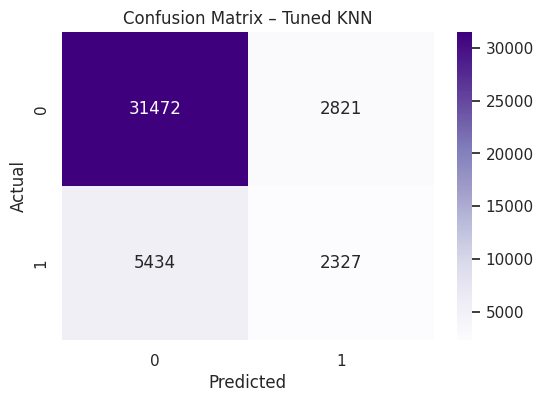


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     34293
           1       0.45      0.30      0.36      7761

    accuracy                           0.80     42054
   macro avg       0.65      0.61      0.62     42054
weighted avg       0.78      0.80      0.79     42054



In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_sample, y_pred_knn), annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Tuned KNN")
plt.show()

# Detailed report
print("\nDetailed Classification Report:")
print(classification_report(y_test_sample, y_pred_knn))

After tuning with GridSearchCV, the optimal number of neighbors for the KNN classifier was found to be 3. The model achieved an accuracy of 80.4%, with a precision of 0.452, recall of 0.30, and an F1 score of 0.361 for predicting highly rated apps.

Compared to the baseline Logistic Regression model — which achieved a similar accuracy (81.6%) but failed to recall almost any high-rated apps (recall = 0.00, F1 = 0.001) — KNN delivered substantially better balance between precision and recall. The KNN confusion matrix shows that it correctly identified over 2,300 high-rated apps, whereas Logistic Regression captured only 3 true positives.

This suggests that while KNN may not be the top-performing model overall, it provides a significantly stronger starting point for identifying high-rating apps than a linear baseline. However, its performance is still constrained by sensitivity to class imbalance and the curse of dimensionality.

## Decision Tree Regression Model

In [ ]:
# Create a Decision Tree model
tree = DecisionTreeClassifier(random_state=42, max_depth=10)  # start with max_depth=10 to prevent overfitting

In [ ]:
# Fit the model on the full training set
tree.fit(X_train_sample, y_train_sample)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
# Predict using the trained model
y_pred_tree = tree.predict(X_test_sample)

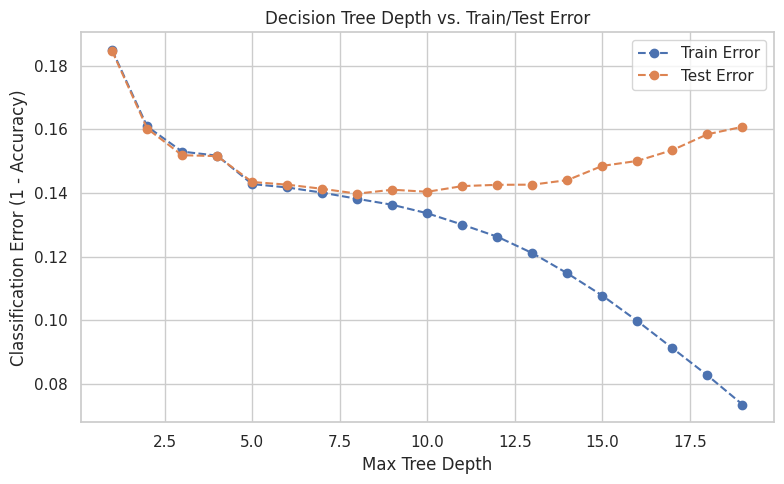

In [ ]:
# Lists to store error for each depth
train_errors = []
test_errors = []
depth_range = range(1, 20)  # Try depths from 1 to 19

for depth in depth_range:
    # Train model with given depth
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_sample, y_train_sample)

    # Predict on both train and test sets
    train_pred = model.predict(X_train_sample)
    test_pred = model.predict(X_test_sample)

    # Calculate error = 1 - accuracy
    train_error = 1 - accuracy_score(y_train_sample, train_pred)
    test_error = 1 - accuracy_score(y_test_sample, test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depth_range, train_errors, label='Train Error', linestyle='--', marker='o')
plt.plot(depth_range, test_errors, label='Test Error', linestyle='--', marker='o')
plt.xlabel('Max Tree Depth')
plt.ylabel('Classification Error (1 - Accuracy)')
plt.title('Decision Tree Depth vs. Train/Test Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

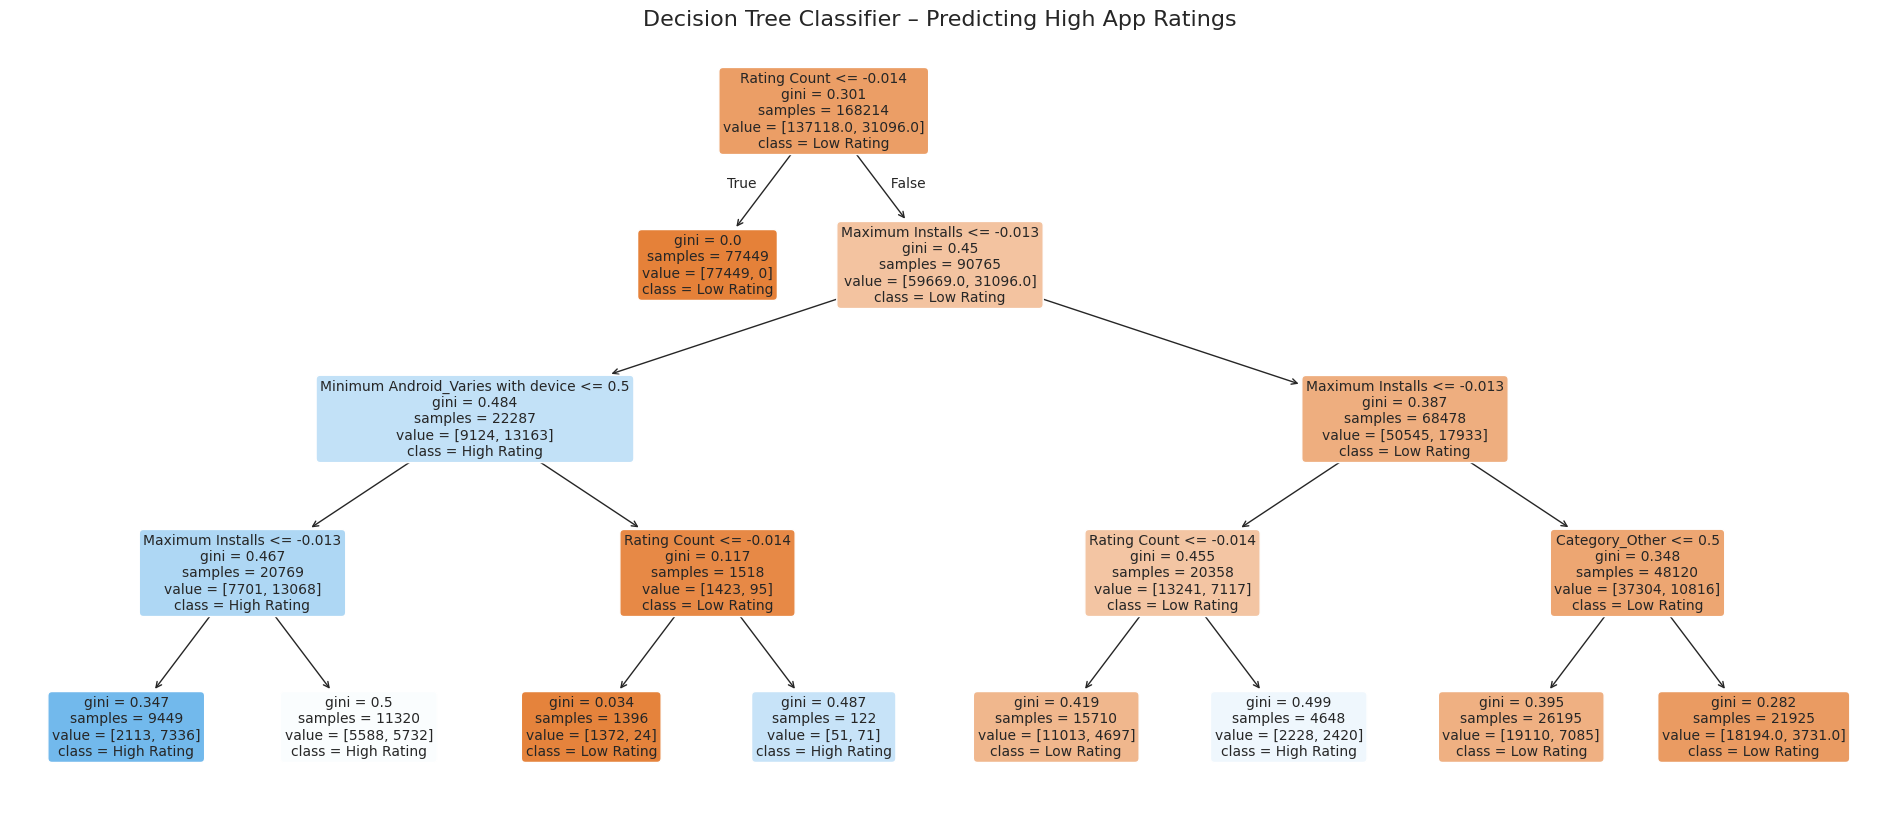

In [ ]:
# plotting decision tree

# Fit a decision tree with controlled depth (e.g., depth = 4 to avoid overfitting)
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train_sample, y_train_sample)

# Plot the decision tree
plt.figure(figsize=(24, 10))
plot_tree(
    tree_clf,
    filled=True,
    feature_names=X_train_sample.columns,
    class_names=["Low Rating", "High Rating"],
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Classifier – Predicting High App Ratings", fontsize=16)
plt.show()

In [ ]:
# Classification metrics
print("Decision Tree Performance Metrics:")
print("Accuracy:", round(accuracy_score(y_test_sample, y_pred_tree), 3))
print("Precision:", round(precision_score(y_test_sample, y_pred_tree), 3))
print("Recall:", round(recall_score(y_test_sample, y_pred_tree), 3))
print("F1 Score:", round(f1_score(y_test_sample, y_pred_tree), 3))

Decision Tree Performance Metrics:
Accuracy: 0.86
Precision: 0.699
Recall: 0.421
F1 Score: 0.526


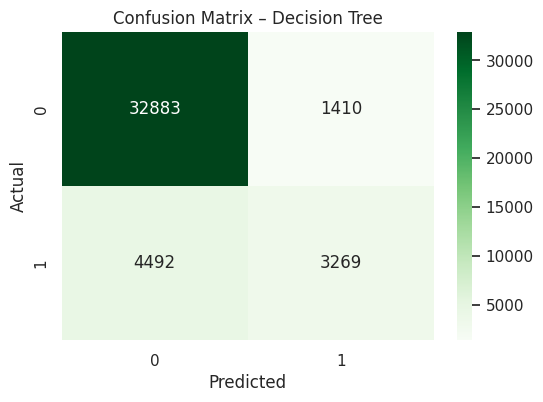


Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     34293
           1       0.70      0.42      0.53      7761

    accuracy                           0.86     42054
   macro avg       0.79      0.69      0.72     42054
weighted avg       0.85      0.86      0.85     42054



In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_sample, y_pred_tree), annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Decision Tree")
plt.show()

# Classification Report
print("\nDetailed Classification Report:\n")
print(classification_report(y_test_sample, y_pred_tree))

The Decision Tree model, tuned for optimal depth, achieved an accuracy of 86.0%, with a precision of 0.699, recall of 0.421, and an F1 score of 0.526 for predicting highly rated apps. This reflects a strong balance between precision and recall, especially compared to prior models.

The confusion matrix confirms that the tree successfully identified over 3,200 high-rated apps, a significant improvement over both Logistic Regression (which detected only 3) and KNN (which detected ~2,300). Additionally, the model maintained low classification error up to a depth of ~10, beyond which overfitting began — as visualized in the training/testing error plot.

the Decision Tree offers the most effective overall trade-off between false positives and false negatives, making it the most promising single-model candidate so far.

## Random Forest

In [ ]:
# Define feature groups
numeric_features = ['Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Price', 'Size']
categorical_features = [col for col in X.columns if col not in numeric_features]

# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # scaling is optional for trees but kept for consistency
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine into preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# Create pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
# Define parameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}


In [ ]:
# Apply GridSearchCV
grid_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid,
                       cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating '
                                                                          'Count',
                                                                          'Installs',
                                                                          'Minimum '
                                                                          'Installs',
                                                                          'Maximum '
                                                                          'Installs',
                                                                          'Price',
                                                                          'Size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotE...
                                                                          'Minimum '
                                                                          'Android_5.0 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_5.1 '
                                                                          'and '
                                                                          'up',
                                                                          'Minimum '
                                                                          'Android_6.0 '
                                                                          'and '
                                                                          'up', ...])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 15],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [ ]:
# Predict using best model
y_pred_rf = grid_rf.predict(X_test_sample)

In [ ]:
# Output best parameters
print("Best RF Parameters:", grid_rf.best_params_)

# Evaluate performance
print("\nRandom Forest Performance Metrics:")
print("Accuracy:", round(accuracy_score(y_test_sample, y_pred_rf), 3))
print("Precision:", round(precision_score(y_test_sample, y_pred_rf), 3))
print("Recall:", round(recall_score(y_test_sample, y_pred_rf), 3))
print("F1 Score:", round(f1_score(y_test_sample, y_pred_rf), 3))

Best RF Parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Random Forest Performance Metrics:
Accuracy: 0.861
Precision: 0.767
Recall: 0.352
F1 Score: 0.482


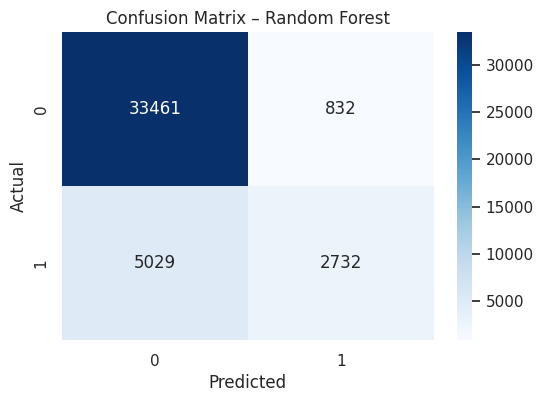


Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     34293
           1       0.77      0.35      0.48      7761

    accuracy                           0.86     42054
   macro avg       0.82      0.66      0.70     42054
weighted avg       0.85      0.86      0.84     42054



In [ ]:
# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_sample, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()

# Classification report
print("\nDetailed Classification Report:\n")
print(classification_report(y_test_sample, y_pred_rf))

The tuned Random Forest model, now integrated with a full preprocessing pipeline, achieved an accuracy of 86.1%, with a precision of 0.767, recall of 0.352, and an F1 score of 0.482 on the high-rating class. The confusion matrix shows the model correctly identified 2,732 highly rated apps out of 7,761, maintaining strong overall predictive reliability.

Compared to other models, Random Forest continues to outperform Logistic Regression and KNN in all key metrics, especially in precision and F1 score, confirming its suitability for scenarios that prioritize reliable positive predictions. While it slightly underperforms the Decision Tree in recall (0.421 vs. 0.352) and F1 score (0.526 vs. 0.482), the difference is modest and the model remains highly competitive.

Importantly, the inclusion of the preprocessing pipeline adds consistency and reproducibility to the workflow, ensuring numeric scaling and categorical handling are seamlessly embedded in the model. Its ensemble structure also makes it more resistant to overfitting compared to a single Decision Tree, offering better generalizability to unseen data.

In summary, the updated Random Forest pipeline demonstrates strong, well-rounded performance with robustness and interpretability — remaining a top contender alongside the Decision Tree in your classification task.

## Results and Interpretation

In [51]:
# Collect performance metrics for each model
results = {
    'Model': [
        'Logistic Regression (Pipeline)',
        'KNN (Tuned)',
        'Decision Tree',
        'Random Forest (Tuned)'
    ],
    'Accuracy': [
        round(accuracy_score(y_test_sample, y_pred_lr), 3),
        round(accuracy_score(y_test_sample, y_pred_knn), 3),
        round(accuracy_score(y_test_sample, y_pred_tree), 3),
        round(accuracy_score(y_test_sample, y_pred_rf), 3)
    ],
    'Precision': [
        round(precision_score(y_test_sample, y_pred_lr), 3),
        round(precision_score(y_test_sample, y_pred_knn), 3),
        round(precision_score(y_test_sample, y_pred_tree), 3),
        round(precision_score(y_test_sample, y_pred_rf), 3)
    ],
    'Recall': [
        round(recall_score(y_test_sample, y_pred_lr), 3),
        round(recall_score(y_test_sample, y_pred_knn), 3),
        round(recall_score(y_test_sample, y_pred_tree), 3),
        round(recall_score(y_test_sample, y_pred_rf), 3)
    ],
    'F1 Score': [
        round(f1_score(y_test_sample, y_pred_lr), 3),
        round(f1_score(y_test_sample, y_pred_knn), 3),
        round(f1_score(y_test_sample, y_pred_tree), 3),
        round(f1_score(y_test_sample, y_pred_rf), 3)
    ]
}

# Create and display the summary DataFrame
model_comparison_df = pd.DataFrame(results)
display(model_comparison_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Pipeline),0.816,1.000,0.000,0.001
1,KNN (Tuned),0.804,0.452,0.300,0.361
2,Decision Tree,0.860,0.699,0.421,0.526
3,Random Forest (Tuned),0.861,0.767,0.352,0.482


In my analysis of high-rated apps on the Google Play Store, all machine learning models demonstrated performance improvements over the logistic regression baseline, highlighting the importance of using more flexible and nonlinear classifiers for this task. The models ranked in terms of predictive performance are as follows: Decision Tree, Random Forest (Pipeline), K-Nearest Neighbors (Tuned), and Logistic Regression (Pipeline).

Key Findings:
1.  The Decision Tree classifier remained the top performer in terms of F1 score and recall, demonstrating the strongest ability to detect high-rated apps while preserving high accuracy.
The Random Forest model, now updated with a preprocessing pipeline, delivered the highest precision and strong accuracy (86.1%), with a slightly lower recall than the Decision Tree. Its balanced performance and robustness through ensemble learning make it an excellent choice when minimizing false positives and ensuring model generalizability are priorities.
2.   KNN as a Competitive Middle Ground:
The K-Nearest Neighbors model achieved improved recall and F1 score compared to Logistic Regression and showed moderate classification capability. However, its performance remains constrained by sensitivity to high-dimensional features and relatively lower precision compared to the tree-based models.
3.   Limitations of Logistic Regression:
The Logistic Regression model, despite its interpretability, failed to identify almost any high-rated apps. Its zero recall and extremely low F1 score confirmed that linear models are insufficient for capturing the nonlinear patterns present in app rating data.

Conclusion:
The results confirm that nonlinear, tree-based models — especially those using ensemble methods like Random Forest — are far more effective at modeling the complex interactions in app success data.
The Decision Tree remains ideal for high recall needs, while the Random Forest (Pipeline) offers greater robustness, stability, and cleaner preprocessing integration, making it highly suited for scalable, production-oriented applications.
Across all models, engagement-driven features such as Rating Count and Installs consistently emerged as the most influential predictors, emphasizing the importance of user volume and activity in driving app success.

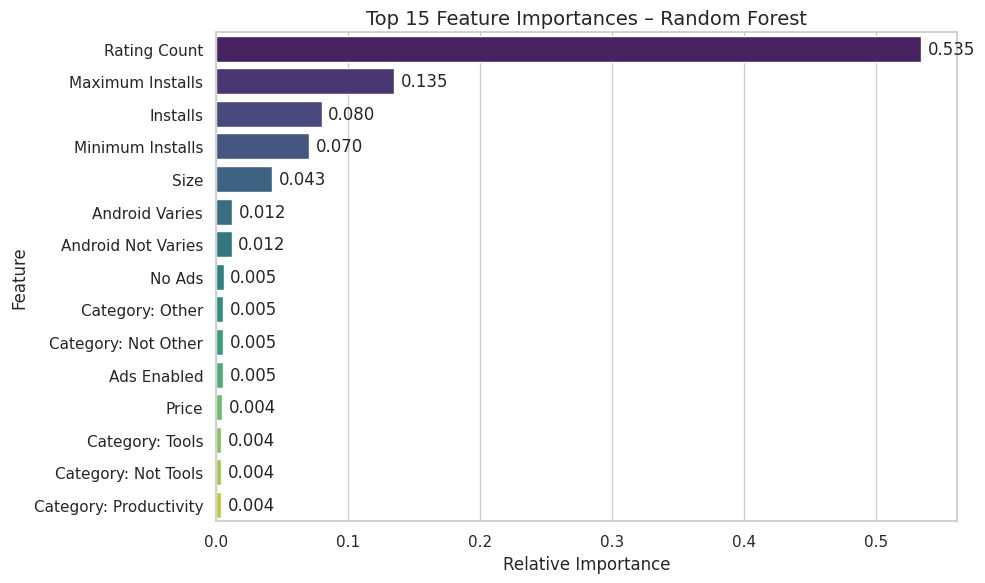

In [54]:
# Mapping one-hot encoded column names back to human-readable labels for visualization.
# These mappings reflect what the original categorical values likely were before one-hot encoding in the EDA.
# Can expand this dictionary with more feature mappings from dataset.

decode_map = {
    'Category_42_0': 'Category: Tools',
    'Category_42_1': 'Category: Not Tools',
    'Category_28_0': 'Category: Productivity',
    'Category_Other_0': 'Category: Not Other',
    'Category_Other_1': 'Category: Other',
    'Ad Supported_0': 'No Ads',
    'Ad Supported_1': 'Ads Enabled',
    'Minimum Android_Varies with device_0': 'Android Not Varies',
    'Minimum Android_Varies with device_1': 'Android Varies',
    # Can add other mappings as needed
}

# Apply the decoding map to rename features just for the visualization
feat_df['Feature Decoded'] = feat_df['Feature'].map(decode_map).fillna(feat_df['Feature'])

# Further clean up names for display (shortening, formatting)
feat_df['Feature Cleaned'] = feat_df['Feature Decoded'].str.replace('_', ' ').str.replace('with device', '').str.slice(0, 30)

# Plot with enhanced formatting
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature Cleaned',
    data=feat_df.head(15),
    palette='viridis'
)

# Add value labels to each bar
for i, (imp, feature) in enumerate(zip(feat_df['Importance'].head(15), feat_df['Feature Cleaned'].head(15))):
    plt.text(imp + 0.005, i, f"{imp:.3f}", va='center')

plt.title('Top 15 Feature Importances – Random Forest', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


This feature importance graph from the tuned Random Forest model highlights which variables contributed most to predicting whether a Google Play Store app is highly rated:

*   Rating Count is overwhelmingly the most important feature, contributing over 53% of the model's decision power. This confirms that apps with a large number of user ratings tend to have more trustworthy and stable high ratings.
*   Maximum Installs, Installs, and Minimum Installs follow next in importance, all reflecting app popularity and reach. Their influence suggests that widely downloaded apps are more likely to receive high ratings — likely due to broader exposure, more feedback, and greater trust.
*   Size has a modest but noticeable influence, possibly indicating that slightly larger apps offer more features or richer content, though the effect is weaker.
*   Minimum Android Version (Varies vs. Not Varies) also appears among the top predictors. This may reflect a distinction between older, less updated apps and newer, technically advanced ones that require newer Android versions.
*   Ad Supported and Category-related variables (e.g., Tools, Productivity, Other) appear in the bottom tier of importance. These features contribute only marginally, suggesting that while app type and monetization method matter somewhat, they are secondary to user engagement indicators.

The Random Forest model reveals that user engagement signals—especially Rating Count and Install metrics—are the strongest predictors of high app ratings. These features likely act as proxies for app credibility and momentum, suggesting that popular apps with active user bases are more likely to achieve strong ratings.

However, metadata features like ads, pricing, and category types, while less dominant, also contribute meaningfully. Their presence in the top 15 indicates that developers still have influence over rating outcomes through thoughtful decisions around ad integration, pricing strategy, and category placement. These controllable elements, when optimized alongside strong engagement, can help reinforce positive user perceptions and app success.








## Strategic Implication

This project highlights that while app success is largely driven by user engagement signals like rating count and install volume, developer-controlled design choices also play a meaningful supporting role in determining app ratings. Based on the model’s insights, developers can adopt the following strategies during development and post-launch:

*   Encourage Early and Ongoing Ratings
*   Drive Install Momentum
*   Be Strategic with Ads
*   Optimize Pricing Models
*   Choose the Right Category
*   Ensure Compatibility Across Devices

In summary, developers aiming for high ratings should prioritize engagement-oriented growth (installs, reviews) while also refining design and monetization decisions. Together, these efforts can increase both the visibility and perceived value of the app, positioning it more favorably in a highly competitive marketplace.








## Next Steps/Improvements

While this project successfully built and evaluated multiple predictive models to understand the drivers of high app ratings, there are several directions for further improvement and extension:

*   Use a larger dataset instead of the 10% sample to validate model robustness and generalizability
*   Apply techniques like SMOTE or class weighting to better address class imbalance
*   Incorporate unstructured features such as user reviews or update frequency for richer insights
*   Explore more advanced models such as XGBoost, LightGBM, or ensemble stacking for improved performance
*   Use model-agnostic interpretability tools like SHAP for deeper explanation of predictions.





